<a href="https://colab.research.google.com/github/rahiakela/opencv-projects-and-guide/blob/main/mastering-opencv4-with-python/11-face-detection-tracking-and-recognition/3_face_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face tracking

Object tracking tries to estimate the trajectory of the target throughout the video sequence where only the initial location of a target is known. This task is really challenging on account of several factors, such as appearance variations, occlusions, fast motion, motion blur, and scale variations.

In this sense, **discriminative correlation filter** (DCF)-based visual trackers provide state-ofthe-art performance. Additionally, these trackers are computationally efficient, which is critical in real-time applications. Indeed, the state-of-the-art performance of DCF-based trackers can be seen in the results of the visual object tracking (VOT) 2014 Challenge.

The dlib library implements a DCF-based tracker, which is easy to use for object tracking. In this notebook, we will see how to use this tracker for both face tracking and for tracking an arbitrary object selected by the user. In the literature, this method is also known as **Discriminative Scale Space Tracker (DSST)**. The only required input (other than the raw video) is a bounding box on the first frame (the initial location of a target) and, then, the
tracker automatically predicts the trajectory of the target.



## Setup

In [ ]:
%%shell

pip install dlib

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

import dlib

In [10]:
def draw_text_info():
  """Draw text information"""

  # We set the position to be used for drawing text and the menu info:
  menu_pos_1 = (10, 20)
  menu_pos_2 = (10, 40)

  # Write text:
  cv2.putText(frame, "Use '1' to re-initialize tracking", menu_pos_1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))
  if tracking_face:
      cv2.putText(frame, "tracking the face", menu_pos_2, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))
  else:
      cv2.putText(frame, "detecting a face to initialize tracking...", menu_pos_2, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

Using a webcam to capture images for processing on the runtime.

https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Face tracking with the dlib DCF-based tracker

We perform face tracking using the dlib frontal face detector for initialization and the dlib DCF-based tracker DSST for face tracking.

<IPython.core.display.Javascript object>

Saved to photo.jpg
30.6707143044401


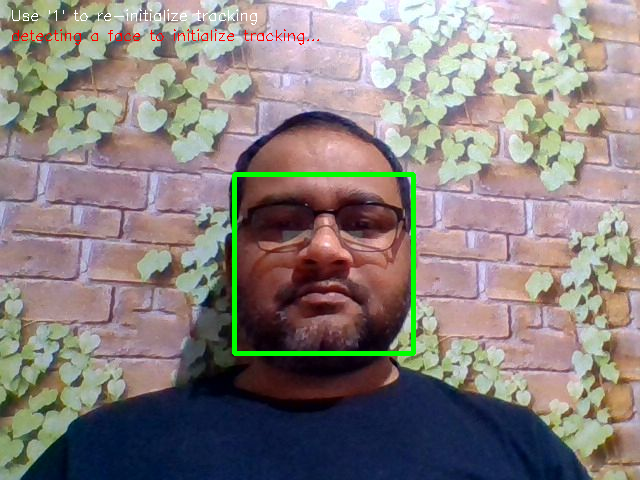

In [ ]:
# take pic from webcam
filename = take_photo()
print('Saved to {}'.format(filename))

# load saved image
test_face = cv2.imread(filename)
frame = test_face.copy()

# Load frontal face detector from dlib
detector = dlib.get_frontal_face_detector()

# We initialize the correlation tracker
tracker = dlib.correlation_tracker()

# This variable will hold if we are currently tracking the face
tracking_face = False

# We draw basic info
draw_text_info()


if tracking_face is False:
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # Try to detect a face to initialize the tracker
  rects = detector(gray, 0)
  # Check if we can start tracking (if we detected a face)
  if len(rects) > 0:
    # Start tracking
    tracker.start_track(frame, rects[0])
    tracking_face = True

if tracking_face is True:
  # Update tracking and print the peak to side-lobe ratio (measures how confident the tracker is)
  print(tracker.update(frame))
  # Get the position of the tracked object
  pos = tracker.get_position()
  # Draw the position
  cv2.rectangle(frame, (int(pos.left()), int(pos.top())), (int(pos.right()), int(pos.bottom())), (0, 255, 0), 3)

# Display the resulting frame
cv2_imshow(frame)

Now let's track face in a video.

https://github.com/intel-iot-devkit/sample-videos

In [ ]:
%%shell

wget https://github.com/intel-iot-devkit/sample-videos/raw/master/head-pose-face-detection-female.mp4
wget https://github.com/intel-iot-devkit/sample-videos/raw/master/head-pose-face-detection-male.mp4

In [ ]:
from IPython.display import clear_output, Image
import base64

video_capture = cv2.VideoCapture("head-pose-face-detection-female.mp4")
while True:
    success, frame = video_capture.read()

    cv2_imshow(frame) # Note cv2_imshow, not cv2.imshow

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

## Object tracking with the dlib DCF-based tracker